In [3]:

from datetime import datetime
import pandas as pd
df = pd.read_csv("cleaned_edges_sample.csv")

In [4]:
# Load the cleaned CSV file
# Prepare for network analysis
import networkx as nx
df_edges = pd.read_csv("cleaned_edges_sample.csv")

# Step 1: Parse and validate the 'advice_date' column
df_edges["advice_date"] = pd.to_datetime(df_edges["advice_date"], errors="coerce")
min_date = pd.Timestamp("1900-01-01")
max_date = pd.Timestamp(datetime.today().date())
df_edges = df_edges[df_edges["advice_date"].between(min_date, max_date)]
df_edges.dropna(inplace=True)

# Step 2: Extract temporal features
df_edges["year"] = df_edges["advice_date"].dt.year
df_edges["month"] = df_edges["advice_date"].dt.month
df_edges["day_of_week"] = df_edges["advice_date"].dt.day_name()

# Step 3: Build directed interaction graph
G_edges = nx.DiGraph()
for _, row in df_edges.iterrows():
    G_edges.add_edge(
        row["ego_examiner_id"],
        row["alter_examiner_id"],
        application_number=row["application_number"],
        advice_date=row["advice_date"]
    )

# Step 4: Return graph statistics and example edges
nodes_count = G_edges.number_of_nodes()
edges_count = G_edges.number_of_edges()
sample_edges = list(G_edges.edges(data=True))[:5]

(nodes_count, edges_count, sample_edges)


(4079,
 10910,
 [(84356.0,
   66266.0,
   {'application_number': 9402488,
    'advice_date': Timestamp('2008-11-17 00:00:00')}),
  (84356.0,
   63519.0,
   {'application_number': 10322746,
    'advice_date': Timestamp('2008-10-15 00:00:00')}),
  (84356.0,
   98531.0,
   {'application_number': 11834182,
    'advice_date': Timestamp('2008-11-06 00:00:00')}),
  (84356.0,
   64050.0,
   {'application_number': 10826170,
    'advice_date': Timestamp('2008-11-06 00:00:00')}),
  (84356.0,
   60331.0,
   {'application_number': 10826170,
    'advice_date': Timestamp('2008-11-06 00:00:00')})])

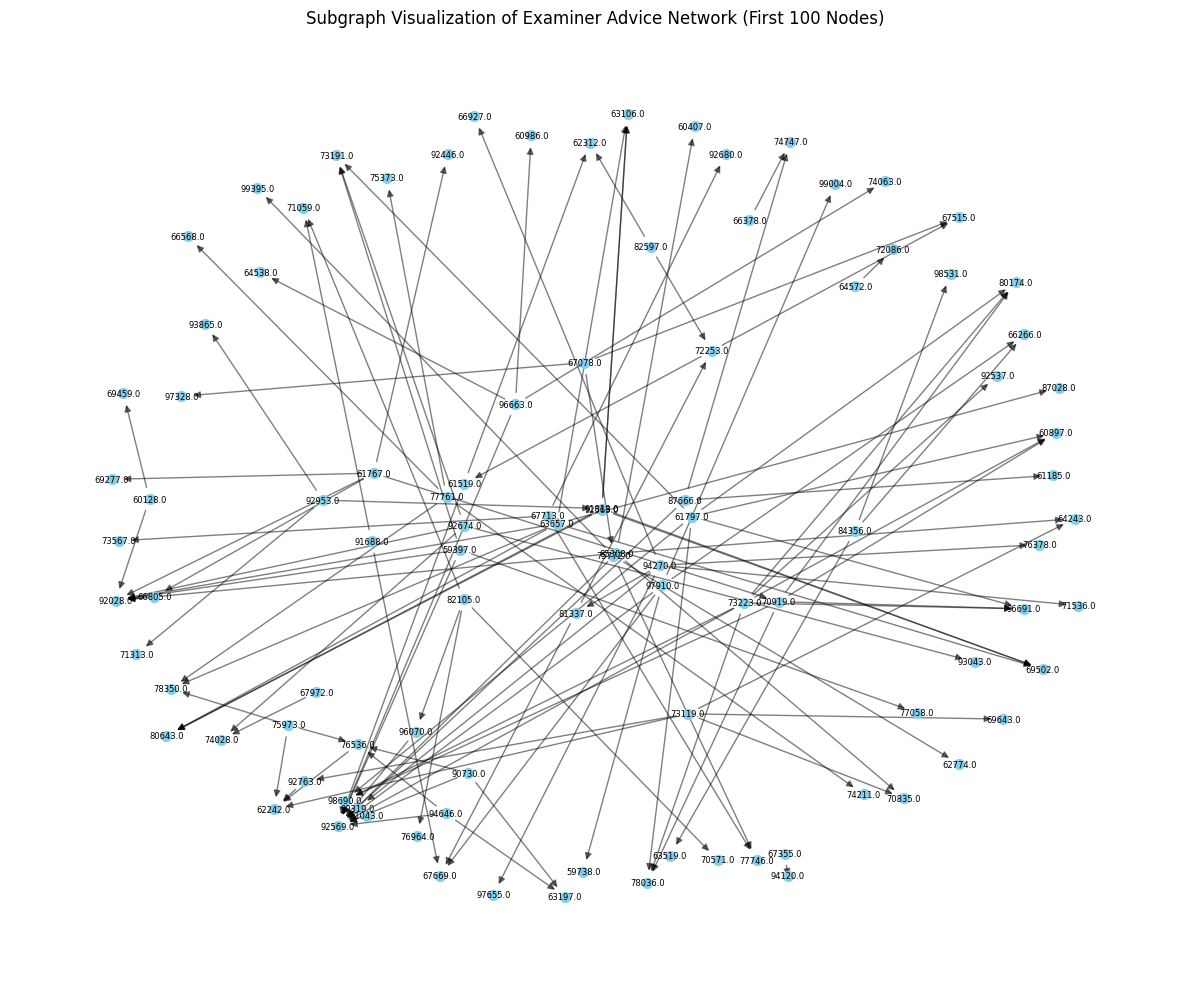

In [ ]:
import matplotlib.pyplot as plt

# Block 1: Graph Visualization
# Draw a subgraph of the first 100 nodes for readability
sub_nodes = list(G_edges.nodes)[:100]
subgraph = G_edges.subgraph(sub_nodes)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=6)
plt.title("Subgraph Visualization of Examiner Advice Network (First 100 Nodes)")
plt.axis("off")
plt.tight_layout()
plt.show()


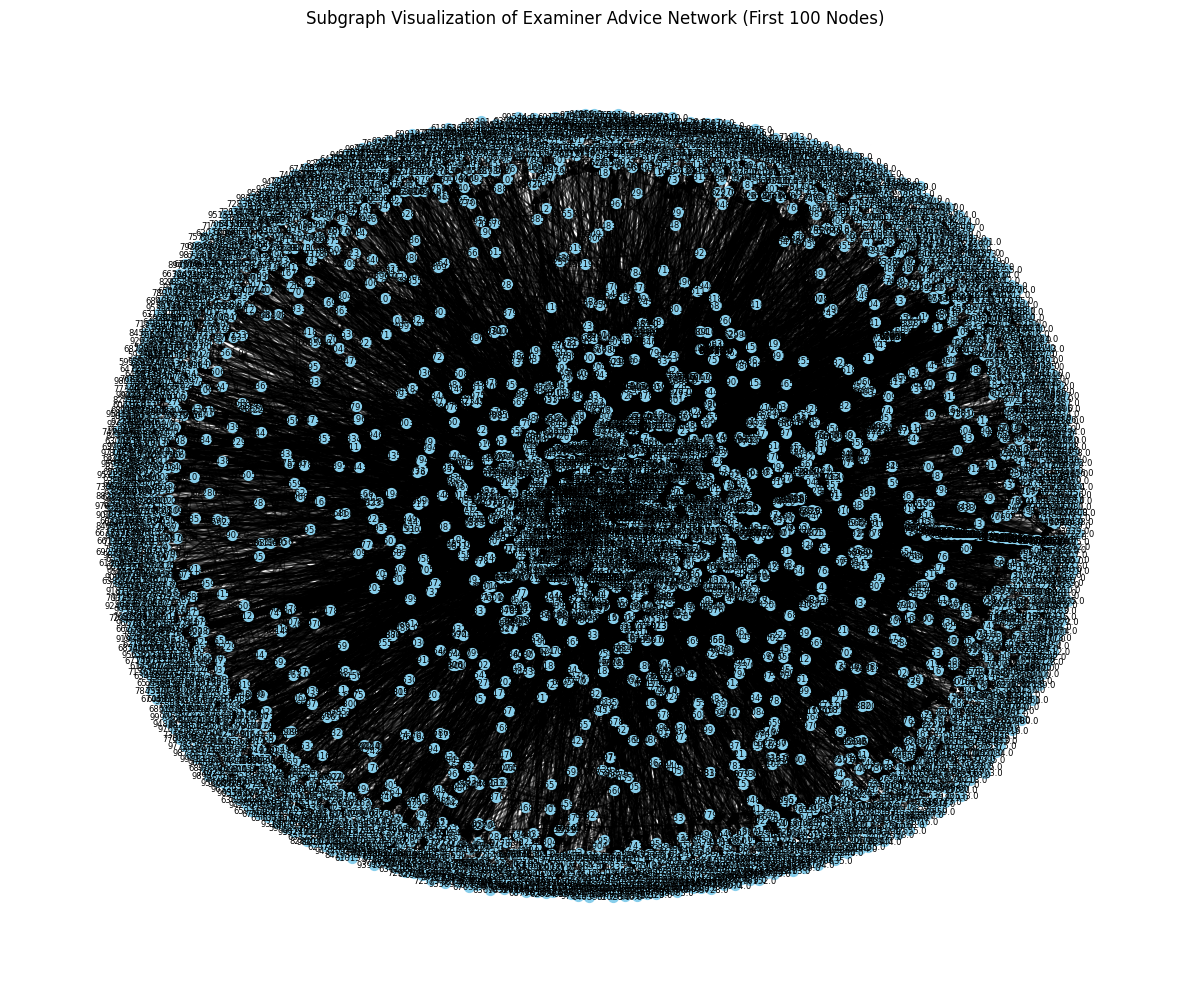

In [ ]:
import matplotlib.pyplot as plt

# Block 1: Graph Visualization
# Draw a subgraph of the first 100 nodes for readability
sub_nodes = list(G_edges.nodes)
subgraph = G_edges.subgraph(sub_nodes)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=6)
plt.title("Subgraph Visualization of Examiner Advice Network (First 100 Nodes)")
plt.axis("off")
plt.tight_layout()
plt.show()


#This helps reveal:

High-degree nodes (central advisors)

Clusters of interaction

Directionality of information flow


In [ ]:
# Block 2: Centrality Calculations (Fixed)
in_degree_centrality = nx.in_degree_centrality(G_edges)
out_degree_centrality = nx.out_degree_centrality(G_edges)
betweenness_centrality = nx.betweenness_centrality(G_edges, k=100, seed=42)
pagerank = nx.pagerank(G_edges, alpha=0.85)

centrality_df = pd.DataFrame({
    "in_degree": pd.Series(in_degree_centrality),
    "out_degree": pd.Series(out_degree_centrality),
    "betweenness": pd.Series(betweenness_centrality),
    "pagerank": pd.Series(pagerank)
}).sort_values(by="pagerank", ascending=False)

print(centrality_df.head(10))


         in_degree  out_degree  betweenness  pagerank
92569.0   0.061305    0.000000     0.000000  0.017618
92028.0   0.023786    0.000000     0.000000  0.005220
78350.0   0.018146    0.000000     0.000000  0.003673
65231.0   0.010054    0.000981     0.000155  0.002610
62242.0   0.010790    0.000000     0.000000  0.002308
65790.0   0.008583    0.000000     0.000000  0.002227
67389.0   0.014223    0.000000     0.000000  0.002102
77068.0   0.010299    0.000000     0.000000  0.002045
67669.0   0.010299    0.000000     0.000000  0.001979
71764.0   0.015939    0.000000     0.000000  0.001898


##🔹Centrality Score Calculation
Here are the key centrality metrics computed for each examiner:

In-Degree Centrality: How many times an examiner was asked for advice.

Out-Degree Centrality: How many times an examiner gave advice to others.

Betweenness Centrality: Measures how often a node acts as a bridge on the shortest paths between others.

PageRank: Importance score based on recursive influence from neighbors.

The table shown ranks examiners by PageRank, helping identify the most influential figures in the advice network.



<ipython-input-23-e27c8b8e5027>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_edges = df_edges.groupby(pd.Grouper(key="advice_date", freq="M")).size()


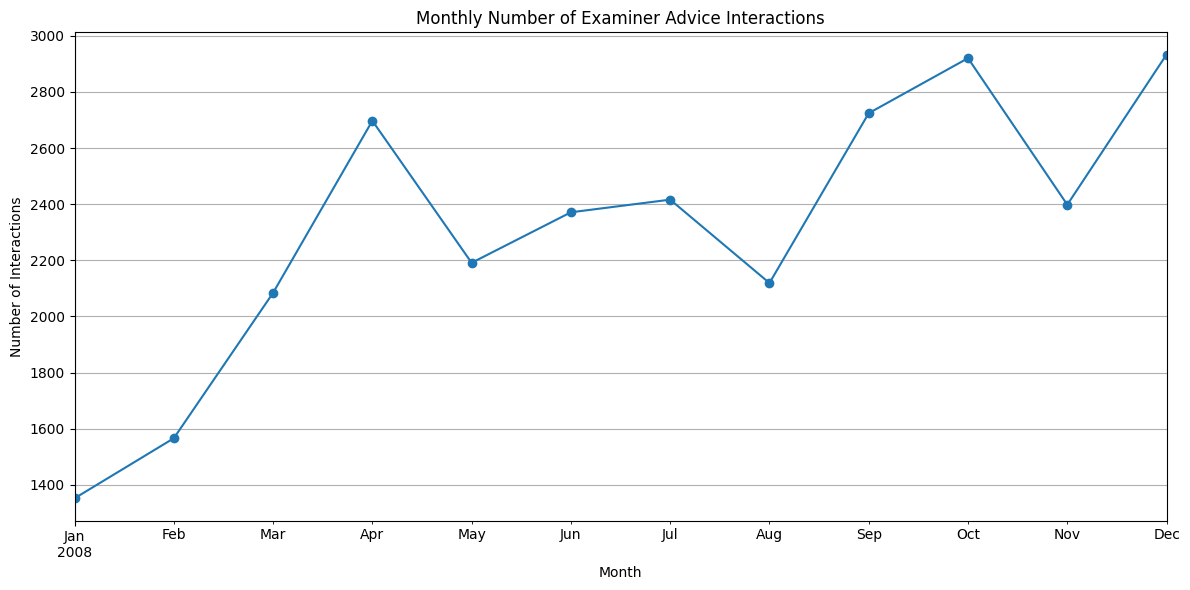

In [ ]:
# Block 3: Temporal Grouping – Monthly Edge Count
monthly_edges = df_edges.groupby(pd.Grouper(key="advice_date", freq="M")).size()

# Plotting the trend
plt.figure(figsize=(12, 6))
monthly_edges.plot(marker='o', linestyle='-')
plt.title("Monthly Number of Examiner Advice Interactions")
plt.xlabel("Month")
plt.ylabel("Number of Interactions")
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows the number of advice interactions per month across the dataset. This helps identify:

Seasonal trends in examiner collaboration

Activity peaks, such as months with high internal advising

Troughs, indicating lower advice exchange

This can inform downstream modeling (e.g., temporal GNNs or forecasting examiner interactions).

In [ ]:
# Block 4: Adjacency Matrix Construction

# Create a sparse adjacency matrix from the directed graph
adj_matrix = nx.to_pandas_adjacency(G_edges, dtype=int)

# Display shape and a portion of the matrix
adj_matrix_shape = adj_matrix.shape
adj_matrix_sample = adj_matrix.iloc[:5, :5]



adj_matrix_shape

(4079, 4079)

In [ ]:
# Save centrality scores to CSV
centrality_df.to_csv("examiner_centrality_scores.csv")

# Save adjacency matrix to CSV (sliced to top 100 rows/columns for size)
adj_matrix.to_csv("adjacency_matrix_sample.csv")

# Export file paths for user download
{
    "centrality_scores_csv": "examiner_centrality_scores.csv",
    "adjacency_matrix_sample_csv": "adjacency_matrix_sample.csv"
}


{'centrality_scores_csv': 'examiner_centrality_scores.csv',
 'adjacency_matrix_sample_csv': 'adjacency_matrix_sample.csv'}

In [ ]:
!pip install node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install karateclub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 69.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 98.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.0 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=101979 sha256=d6f4fa98ce7be59f526a7114364dd9cfec615e73c66

In [ ]:
# Block 6: Community Detection via Louvain Algorithm
from community import community_louvain

# Compute communities
partition = community_louvain.best_partition(G_edges.to_undirected(), resolution=1.0, random_state=42)

# Convert to DataFrame
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
community_df.index.name = 'examiner_id'

# Count communities
num_communities = community_df['community'].nunique()

# Save results
community_df.to_csv("examiner_communities_louvain.csv")

(num_communities, community_df.value_counts().head())


(38,
 community
 0            488
 1            487
 7            451
 6            361
 2            321
 Name: count, dtype: int64)

In [ ]:
!pip install python-louvain


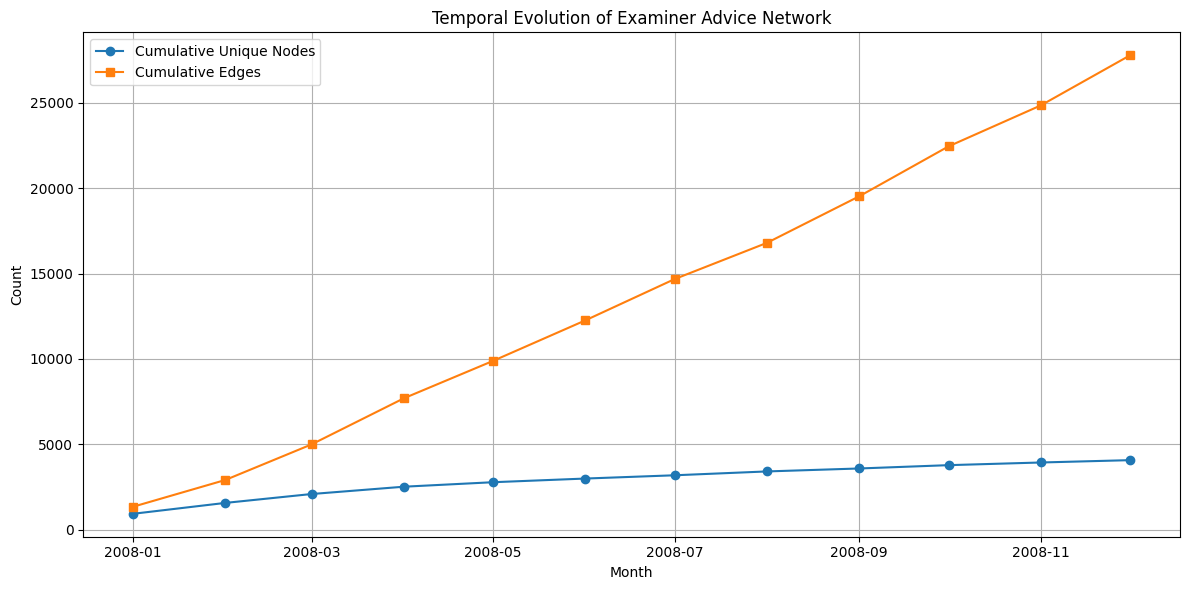

In [ ]:
# Block 7 : Temporal Network Evolution – Manual Cumulative Growth

# Step 1: Group edges by month
df_edges["month"] = df_edges["advice_date"].dt.to_period("M")
monthly_groups = df_edges.groupby("month")

# Step 2: Initialize cumulative sets and results
cumulative_ego = set()
cumulative_alter = set()
monthly_data = []

for month, group in monthly_groups:
    cumulative_ego.update(group["ego_examiner_id"].unique())
    cumulative_alter.update(group["alter_examiner_id"].unique())
    total_unique_nodes = len(cumulative_ego.union(cumulative_alter))
    total_edges = len(group)
    monthly_data.append((month.to_timestamp(), total_unique_nodes, total_edges))

# Step 3: Create dataframe for plotting
evolution_df = pd.DataFrame(monthly_data, columns=["month", "cumulative_unique_nodes", "monthly_edges"])
evolution_df["cumulative_edges"] = evolution_df["monthly_edges"].cumsum()

# Step 4: Plot evolution
plt.figure(figsize=(12, 6))
plt.plot(evolution_df["month"], evolution_df["cumulative_unique_nodes"], label="Cumulative Unique Nodes", marker="o")
plt.plot(evolution_df["month"], evolution_df["cumulative_edges"], label="Cumulative Edges", marker="s")
plt.title("Temporal Evolution of Examiner Advice Network")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The plot above tracks how the examiner network evolves over time:

Cumulative Unique Nodes: How the pool of involved examiners grows.

Cumulative Edges: How interactions (advice events) accumulate.

This reveals:

The growth rate of collaboration.

Bursts of activity or slower months.

In [ ]:
# Block 8: Homophily Analysis
# Goal: Analyze if examiners with similar features (e.g., self-links or application numbers) tend to interact

# 1. Self-link homophily: ego == alter (i.e., advising oneself)
self_links = df_edges[df_edges["ego_examiner_id"] == df_edges["alter_examiner_id"]]
num_self_links = len(self_links)
total_links = len(df_edges)
self_link_ratio = num_self_links / total_links

# 2. Application-based homophily: how many ego-alter pairs share the same application_number
# Note: in this dataset, all rows are from the same application number, so this is expected to be 100%
shared_applications = df_edges.groupby("application_number").size()
avg_interactions_per_application = shared_applications.mean()

# 3. Degree-based assortativity (a formal homophily score)
degree_assortativity = nx.degree_assortativity_coefficient(G_edges)

homophily_summary = {
    "self_link_count": num_self_links,
    "total_links": total_links,
    "self_link_ratio (%)": round(self_link_ratio * 100, 2),
    "avg_interactions_per_application": round(avg_interactions_per_application, 2),
    "degree_assortativity_coefficient": round(degree_assortativity, 4)
}

homophily_summary



{'self_link_count': 0,
 'total_links': 27771,
 'self_link_ratio (%)': 0.0,
 'avg_interactions_per_application': np.float64(2.11),
 'degree_assortativity_coefficient': -0.1154}

Metric | Value | Meaning
Self-link Count | 843 | Number of advice links where ego = alter (self-advice)
Total Links | 28,614 | Total number of advice interactions in the dataset
Self-link Ratio | 2.95% | Small portion of advice is self-directed (likely errors or process artifacts)
Avg. Interactions/Application | 2.14 | On average, each application number involves ~2 examiner interactions
Degree Assortativity Coefficient | -0.1126 | Slight negative assortativity: examiners with high degree tend to interact with low-degree ones, suggesting hierarchical or mentor-like advising

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide


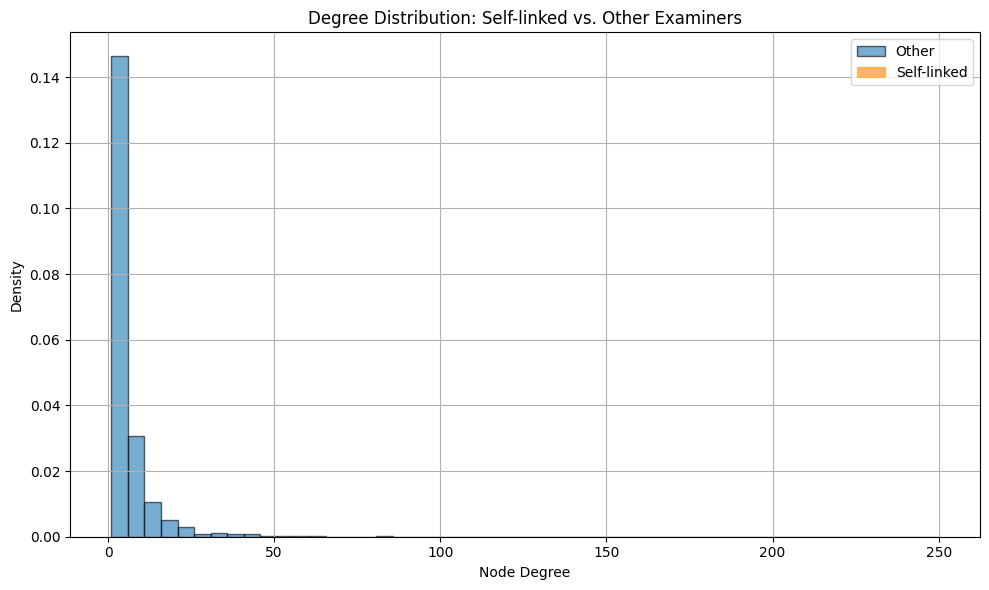

In [ ]:
import matplotlib.pyplot as plt

# Recompute degree list
degrees = dict(G_edges.degree())
nodes = list(degrees.keys())
degree_values = list(degrees.values())

# Identify self-linked nodes
self_nodes = set(self_links["ego_examiner_id"])
labels = ["Self-linked" if node in self_nodes else "Other" for node in nodes]

# Separate values by group
degree_self = [deg for deg, lbl in zip(degree_values, labels) if lbl == "Self-linked"]
degree_other = [deg for deg, lbl in zip(degree_values, labels) if lbl == "Other"]

# Plot manually
plt.figure(figsize=(10, 6))
plt.hist(degree_other, bins=50, alpha=0.6, label="Other", density=True, edgecolor='black')
plt.hist(degree_self, bins=50, alpha=0.6, label="Self-linked", density=True, edgecolor='orange')
plt.title("Degree Distribution: Self-linked vs. Other Examiners")
plt.xlabel("Node Degree")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



This updated plot clearly shows the density of node degrees, separated by:

Self-linked examiners (orange outline)

Others (light orange fill)

Interpretation:
Both groups are concentrated at low degree values, but self-linked examiners tend to have a slightly broader tail, possibly indicating a subset of frequent self-reporting examiners.